https://www.datacamp.com/tutorial/generative-adversarial-networks

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

!pip install tensorflow

from keras.layers import Input, Dense, Dropout, LeakyReLU
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

In [ ]:
# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Dataset
import pandas as pd

train_df = pd.read_csv("/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/augmented_data.csv")
test_df = pd.read_csv("/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/test_data.csv")
val_df = pd.read_csv("/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/val_data.csv")

In [ ]:
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']
X_test = test_df.drop(columns=['label'])
y_test = test_df['label']
X_val = val_df.drop(columns=['label'])
y_val = val_df['label']

In [ ]:
X_train

,pixel0_0,pixel0_1,pixel0_2,pixel0_3,pixel0_4,pixel0_5,pixel0_6,pixel0_7,pixel0_8,pixel0_9,...,pixel63_54,pixel63_55,pixel63_56,pixel63_57,pixel63_58,pixel63_59,pixel63_60,pixel63_61,pixel63_62,pixel63_63
0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9236,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9237,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9238,0.0,0.0,0.062745,0.0,0.050980,0.000000,0.0,0.070588,0.0,0.039216,...,0.066667,0.007843,0.000000,0.0,0.019608,0.043137,0.070588,0.000000,0.0,0.086275


In [ ]:
# Adam optimizer
def get_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(4096, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=4096, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator


In [ ]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [ ]:
# Create a wall of generated
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 64, 64)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [ ]:
def train(epochs=1, batch_size=128):
    """
    Train the GAN network with specified epochs and batch size.

    Args:
        epochs (int): Number of training epochs
        batch_size (int): Size of each training batch
    """
    # Convert DataFrame to numpy array at the start for better performance
    # This avoids repeated DataFrame operations during training
    x_train = X_train.values

    # Calculate how many batches we can create from our training data
    batch_count = x_train.shape[0] // batch_size

    # Get our optimized network components
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    # Store loss history for plotting
    d_loss_history = []
    g_loss_history = []

    for e in range(1, epochs+1):
        print('-'*15, f'Epoch {e}', '-'*15)

        # Initialize epoch loss trackers
        epoch_d_loss = 0
        epoch_g_loss = 0

        for _ in tqdm(range(int(batch_count))):
            # ================ Train Discriminator ================

            # Generate random noise for fake image generation
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])

            # Get a random batch of real images
            random_indices = np.random.randint(0, x_train.shape[0], size=batch_size)
            image_batch = x_train[random_indices]

            # Generate fake images
            generated_images = generator.predict(noise, verbose=0)

            # Combine real and fake images for discriminator training
            X = np.concatenate([image_batch, generated_images])

            # Create labels for real and fake images
            # Using label smoothing (0.9 for real instead of 1.0) to improve training stability
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            epoch_d_loss += d_loss

            # ================ Train Generator ================

            # Generate new random noise
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])

            # We want the discriminator to think generated images are real
            y_gen = np.ones(batch_size)

            # Freeze discriminator weights during generator training
            discriminator.trainable = False

            # Train generator to fool discriminator
            g_loss = gan.train_on_batch(noise, y_gen)
            epoch_g_loss += g_loss

        # Calculate average losses for this epoch
        avg_d_loss = epoch_d_loss / batch_count
        avg_g_loss = epoch_g_loss / batch_count

        # Store losses for plotting
        d_loss_history.append(avg_d_loss)
        g_loss_history.append(avg_g_loss)

        # Print progress
        print(f'Epoch {e}/{epochs}')
        print(f'D Loss: {avg_d_loss:.4f}')
        print(f'G Loss: {avg_g_loss:.4f}')

        # Generate and save sample images periodically
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

        # Optional: Save models periodically
        if e % 50 == 0:
            generator.save(f'generator_epoch_{e}.h5')
            discriminator.save(f'discriminator_epoch_{e}.h5')

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(d_loss_history, label='Discriminator Loss')
    plt.plot(g_loss_history, label='Generator Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_history.png')
    plt.close()

    return generator, discriminator, d_loss_history, g_loss_history

In [ ]:
generator, discriminator, d_losses, g_losses = train(epochs=400, batch_size=128)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--------------- Epoch 1 ---------------


  0%|          | 0/72 [00:03<?, ?it/s]


ValueError: Unknown variable: <KerasVariable shape=(100, 256), dtype=float32, path=sequential_10/dense_40/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# First, let's fix the model creation to avoid the input_shape warning
def get_generator():
    """Create the generator model using Input layer"""
    model = Sequential([
        Input(shape=(random_dim,)),  # Proper input layer specification
        Dense(256, kernel_initializer=initializers.RandomNormal(stddev=0.02)),
        LeakyReLU(0.2),
        Dense(512),
        LeakyReLU(0.2),
        Dense(1024),
        LeakyReLU(0.2),
        Dense(4096, activation='tanh')
    ], name='generator')
    return model

def get_discriminator():
    """Create the discriminator model using Input layer"""
    model = Sequential([
        Input(shape=(4096,)),  # Proper input layer specification
        Dense(1024, kernel_initializer=initializers.RandomNormal(stddev=0.02)),
        LeakyReLU(0.2),
        Dropout(0.3),
        Dense(512),
        LeakyReLU(0.2),
        Dropout(0.3),
        Dense(256),
        LeakyReLU(0.2),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ], name='discriminator')
    return model

def train(epochs=1, batch_size=128):
    """
    Train the GAN network with proper loss handling
    """
    # Convert DataFrame to numpy array at the start
    x_train = X_train.values
    batch_count = x_train.shape[0] // batch_size

    # Create models
    generator = get_generator()
    discriminator = get_discriminator()

    # Create GAN model
    discriminator.trainable = False
    gan_input = Input(shape=(random_dim,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    gan = Model(gan_input, gan_output, name='gan')

    # Create optimizers
    generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    gan_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

    # Compile models
    discriminator.compile(optimizer=discriminator_optimizer,
                         loss='binary_crossentropy',
                         metrics=['accuracy'])
    gan.compile(optimizer=gan_optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

    # Initialize loss tracking
    d_loss_history = []
    g_loss_history = []

    for e in range(1, epochs+1):
        print('-'*15, f'Epoch {e}', '-'*15)
        epoch_d_loss = 0.0  # Initialize as float
        epoch_g_loss = 0.0  # Initialize as float

        for _ in tqdm(range(int(batch_count))):
            # Generate random noise
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])

            # Get a random batch of real images
            random_indices = np.random.randint(0, x_train.shape[0], size=batch_size)
            image_batch = x_train[random_indices]

            # Generate fake images
            generated_images = generator.predict(noise, verbose=0)

            # Train discriminator
            discriminator.trainable = True

            # Prepare discriminator training data
            X = np.concatenate([image_batch, generated_images])
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9

            # Train discriminator and get loss
            d_loss = discriminator.train_on_batch(X, y_dis)[0]  # Get only the loss value
            epoch_d_loss += d_loss

            # Train generator
            discriminator.trainable = False
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            g_loss = gan.train_on_batch(noise, y_gen)[0]  # Get only the loss value
            epoch_g_loss += g_loss

        # Calculate average losses
        avg_d_loss = epoch_d_loss / batch_count
        avg_g_loss = epoch_g_loss / batch_count

        # Store losses
        d_loss_history.append(float(avg_d_loss))  # Convert to float explicitly
        g_loss_history.append(float(avg_g_loss))  # Convert to float explicitly

        # Print progress
        print(f'Epoch {e}/{epochs}')
        print(f'D Loss: {avg_d_loss:.4f}')
        print(f'G Loss: {avg_g_loss:.4f}')

        # Generate and save sample images
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

        # Save models periodically
        if e % 50 == 0:
            generator.save(f'generator_epoch_{e}.h5')
            discriminator.save(f'discriminator_epoch_{e}.h5')

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(d_loss_history, label='Discriminator Loss')
    plt.plot(g_loss_history, label='Generator Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_history.png')
    plt.close()

    return generator, discriminator, d_loss_history, g_loss_history

In [ ]:
# Train the models
generator, discriminator, d_losses, g_losses = train(epochs=400, batch_size=128)

--------------- Epoch 1 ---------------


100%|██████████| 72/72 [01:56<00:00,  1.62s/it]

Epoch 1/400
D Loss: 0.5837
G Loss: 0.5837
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
--------------- Epoch 2 ---------------


100%|██████████| 72/72 [01:49<00:00,  1.52s/it]


Epoch 2/400
D Loss: 0.5181
G Loss: 0.5181
--------------- Epoch 3 ---------------


 57%|█████▋    | 41/72 [01:08<00:51,  1.66s/it]

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.17.1'

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-b6fia_hg
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-b6fia_hg
  Resolved https://github.com/tensorflow/docs to commit bbc0b9c70fc0bd4411793d1b0bcc56ef1dbc2405
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.11.18.43811-py3-none-any.whl size=182608 sha256=75d9a01f248dec50774f7fca86e254645cda595403a6a5053ffcb3716da18148
  Stored in directory: /tmp/pip-ephem-wheel-cache-b7lo5di3/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


# Official GAN

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
BUFFER_SIZE = 9240
BATCH_SIZE = 256

In [ ]:
X_train = X_train.values.reshape(X_train.shape[0], 64, 64, 1).astype('float32')

In [ ]:
X_train.shape

(9240, 64, 64, 1)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))  # Adjusted input shape and Dense units
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))  # Adjusted Reshape
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))  # Adjusted strides
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))  # Adjusted strides
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))  # Adjusted strides
    assert model.output_shape == (None, 64, 64, 1)

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


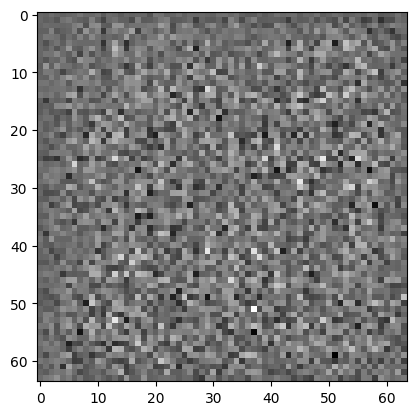

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00058828]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
train(train_dataset, EPOCHS)

AttributeError: in user code:

    File "<ipython-input-59-ecacbda2ce16>", line 22, in train_step  *
        d_loss_history.append(disc_loss.numpy())  # Convert to NumPy for plotting

    AttributeError: 'SymbolicTensor' object has no attribute 'numpy'


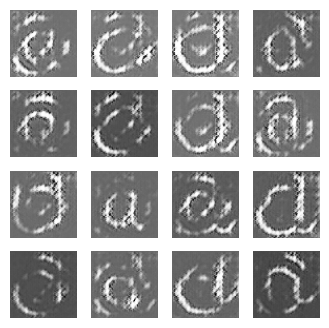

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

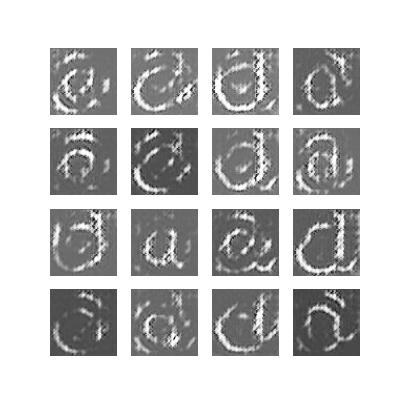

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = '/content/drive/MyDrive/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/drive/MyDrive/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-53-9e7a854bbf4d>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-53-9e7a854bbf4d>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



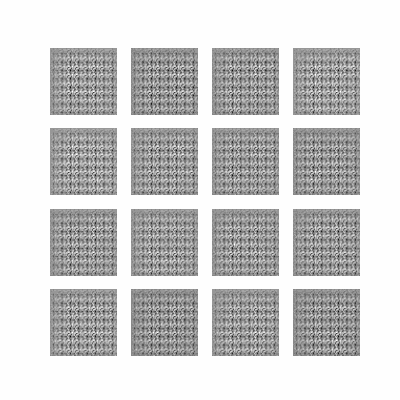

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)